# Импорт библиотек

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve,GridSearchCV

# Подготовка и анализ данных

In [184]:
df=pd.read_csv("noise.csv")
df

,Частота в герцах;Угол атаки;Длина хорды; Скорость набегающего потока;Толщина смещения;уровень звукового давления
0,800;0;0.3048;71.3;0.00266337;126.201
1,1000;0;0.3048;71.3;0.00266337;125.201
2,1250;0;0.3048;71.3;0.00266337;125.951
3,1600;0;0.3048;71.3;0.00266337;127.591
4,2000;0;0.3048;71.3;0.00266337;127.461
...,...
1502,6300;15.6;0.1016;39.6;0.0528487;104.204
1503,;;;;;
1504,;;;;;
1505,;;;;;


Датасет был загружен некорректно, так как в качестве разделителя используется точка с запятой. Учтем этот факт:

In [185]:
df=pd.read_csv("noise.csv", sep=";")
df

,Частота в герцах,Угол атаки,Длина хорды,Скорость набегающего потока,Толщина смещения,уровень звукового давления
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,2000.0,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1502,6300.0,15.6,0.1016,39.6,0.052849,104.204
1503,NaN,NaN,NaN,NaN,NaN,NaN
1504,NaN,NaN,NaN,NaN,NaN,NaN
1505,NaN,NaN,NaN,NaN,NaN,NaN


Датасет представлен 6 столбцами данных, отражающих зависимость уровня звукового давления в аэродинамической трубе от частоты, угла атаки, длины хорды, скорости потока и толщины смещения. Требуется построить модель для предсказания значения целевой переменной (уровня звукового давления). Исследуем характеристики данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Частота в герцах              1503 non-null   float64
 1   Угол атаки                    1503 non-null   float64
 2   Длина хорды                   1503 non-null   float64
 3    Скорость набегающего потока  1503 non-null   float64
 4   Толщина смещения              1503 non-null   float64
 5   уровень звукового давления    1503 non-null   float64
dtypes: float64(6)
memory usage: 70.8 KB


Представлено 1503 непустых строки (пустые расположены в хвосте). Все данные имеют тип числа с плавающей точкой. Рассмотрим статистические характеристики.

In [5]:
df.describe()

,Частота в герцах,Угол атаки,Длина хорды,Скорость набегающего потока,Толщина смещения,уровень звукового давления
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


Частота колеблется от 200 до 20 000 герц со средним значением 2886 и СКО 3153. Угол атаки колеблется от 0 до 22 градусов, при том 3/4 значений не превышают 10 градусов. Длина хорды в среднем составляет 14 см. Скорость набегающего потока составлет в среднем 51 м/с с отклонением 16 м/с. Толщина смещения находится в диапазоне от 0,04 см до 6 см при среднем значении и СКО 1 см. Значение целевой переменной в среднем составляет 125 дб, минимальный уровень давления-103 дб, максимальный-141 дб.    

Удалим 4 пропущенных значения:

In [186]:
df.dropna(inplace=True)

Т.к. частота представлена целым числом и выражается в герцах, преобразуем данные в столбце в целочисленные.

In [187]:
df["Частота в герцах"] = df['Частота в герцах'].astype('int')

Для удобства дальнейшей работы переименуем столбцы на латинице:

In [188]:
df=df.rename(columns={"Частота в герцах":"Frequency_in_hertz","Угол атаки":"Attack_angle", "Длина хорды":"Chord_length", " Скорость набегающего потока":"Running_stream_speed", "Толщина смещения":"Offset_thickness", "уровень звукового давления ":"Sound_pressure_level"})

Преобразованный датасет имеет вид:

In [9]:
df

,Frequency_in_hertz,Attack_angle,Chord_length,Running_stream_speed,Offset_thickness,Sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Исследуем графически распределение данных

array([[<Axes: title={'center': 'Frequency_in_hertz'}>,
        <Axes: title={'center': 'Attack_angle'}>],
       [<Axes: title={'center': 'Chord_length'}>,
        <Axes: title={'center': 'Running_stream_speed'}>],
       [<Axes: title={'center': 'Offset_thickness'}>,
        <Axes: title={'center': 'Sound_pressure_level'}>]], dtype=object)

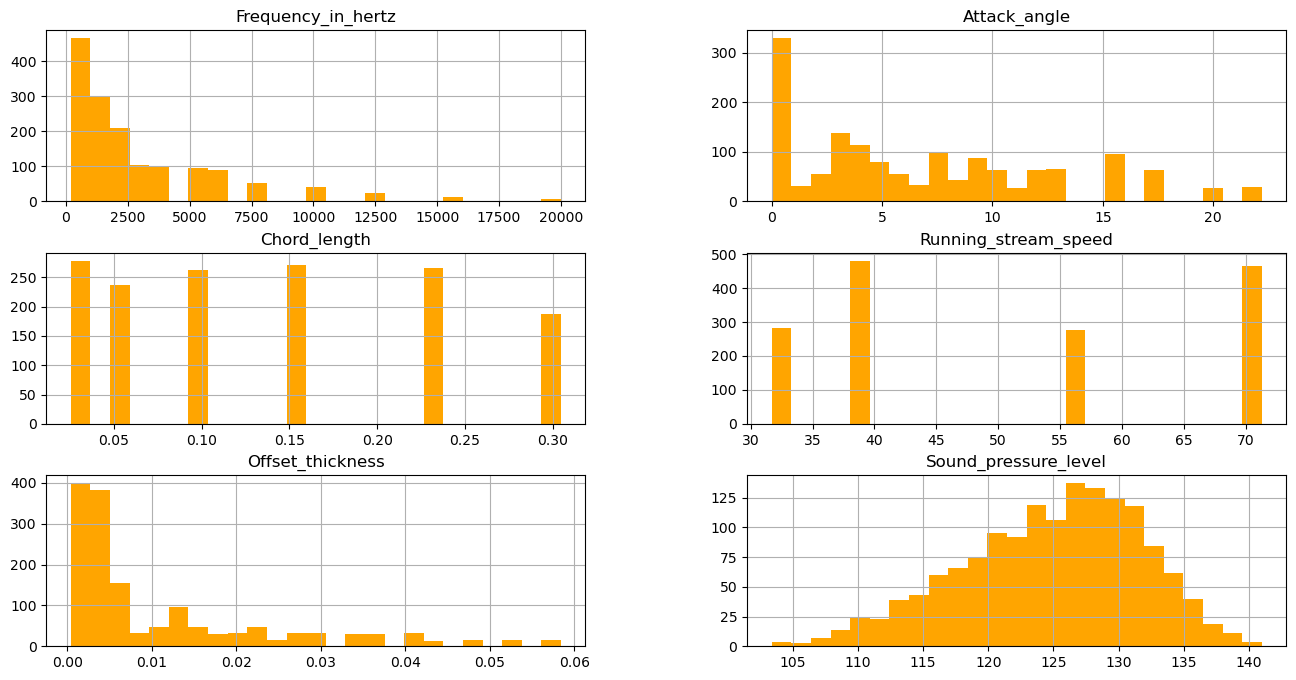

In [10]:
df.hist(bins=25,figsize=(16,8),color='orange')

Частота, угол атаки и толщина смещения имеют геометрическое распределение, длина хорды и скорость потока-равномерное, значения уровня звукового давления распределены по закону, близкому к нормальному.

Рассмотрим влияние признаков на целевое значение.

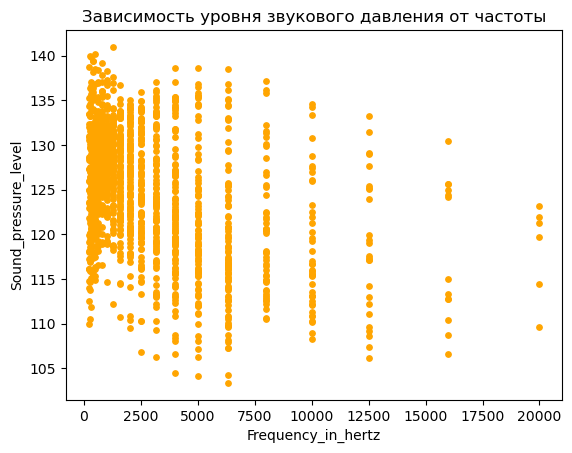

In [11]:
plt.scatter(df.Frequency_in_hertz, df.Sound_pressure_level, s=15, c='orange')
plt.xlabel("Frequency_in_hertz")
plt.ylabel("Sound_pressure_level")
plt.title("Зависимость уровня звукового давления от частоты")
plt.show()

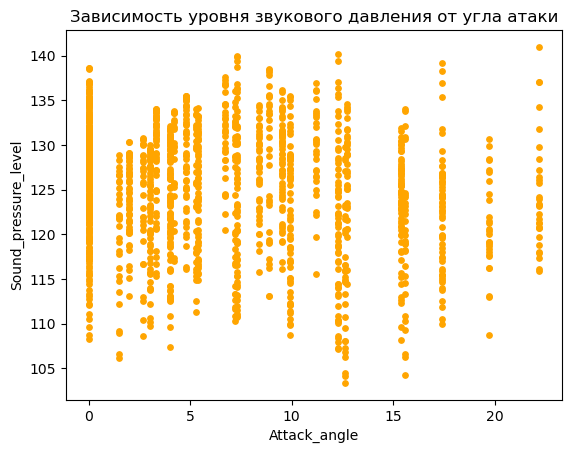

In [12]:
plt.scatter(df.Attack_angle, df.Sound_pressure_level, s=15, c='orange')
plt.xlabel("Attack_angle")
plt.ylabel("Sound_pressure_level")
plt.title("Зависимость уровня звукового давления от угла атаки")
plt.show()

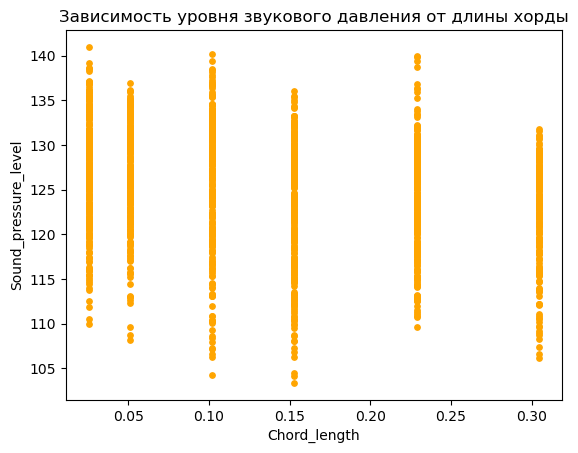

In [13]:
plt.scatter(df.Chord_length, df.Sound_pressure_level,s=15, c='orange')
plt.xlabel("Chord_length")
plt.ylabel("Sound_pressure_level")
plt.title("Зависимость уровня звукового давления от длины хорды")
plt.show()

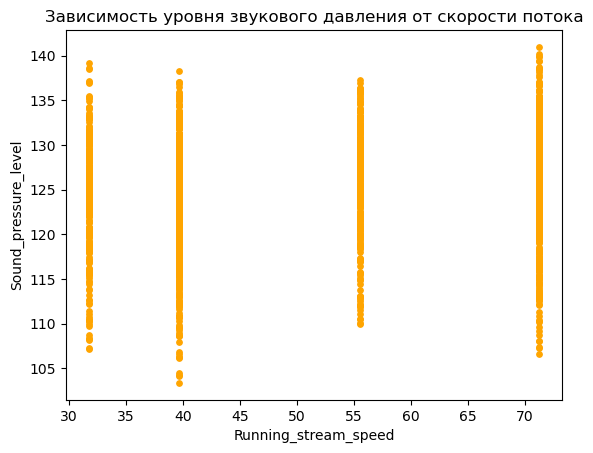

In [14]:
plt.scatter(df.Running_stream_speed, df.Sound_pressure_level,s=15, c='orange')
plt.xlabel("Running_stream_speed")
plt.ylabel("Sound_pressure_level")
plt.title("Зависимость уровня звукового давления от скорости потока")
plt.show()

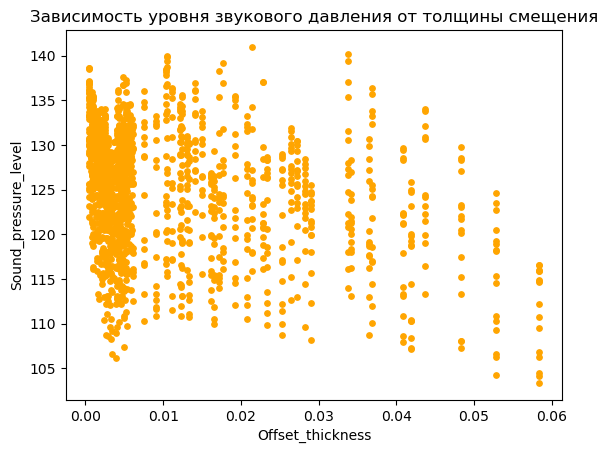

In [15]:
plt.scatter(df.Offset_thickness, df.Sound_pressure_level,s=15, c='orange')
plt.xlabel("Offset_thickness")
plt.ylabel("Sound_pressure_level")
plt.title("Зависимость уровня звукового давления от толщины смещения")
plt.show()

Анализ графиков показывает, что при меньших значениях частоты и толщины смещения наиболее вероятно получить близкий к среднему уровень давления. Влияние остальных признаков трудно определить, исследуем его с помощью матрицы корреляции.

In [16]:
corr_matryx=df.corr()
corr_matryx.style.background_gradient(cmap='coolwarm', axis=None)

,Frequency_in_hertz,Attack_angle,Chord_length,Running_stream_speed,Offset_thickness,Sound_pressure_level
Frequency_in_hertz,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Attack_angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Chord_length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Running_stream_speed,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Offset_thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
Sound_pressure_level,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


Так, на значения целевой переменной действительно оказывают наибольшее влияние частота и толщина смещения, но связь около 0,3 может быть оценена как слабая. Высокой теснотой обладает связь признаков угла атаки и толщины смещения, средней - угла атаки и длины хорды, что свидетельствует об их мультиколлинеарности и может вести к дальнейшему переобучению модели. В таком случае целесообразно удалить один из факторов (тот, который наиболее связан с другими переменными) или минимизировать воздействие с помощью регуляризации.

In [193]:
df1 = df.copy(deep=True)
df_clean1 = df1[['Frequency_in_hertz', 'Chord_length','Running_stream_speed','Offset_thickness','Sound_pressure_level']]
df_clean1.describe()

,Frequency_in_hertz,Chord_length,Running_stream_speed,Offset_thickness,Sound_pressure_level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,0.136548,50.860745,0.011140,124.835943
std,3152.573137,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,0.304800,71.300000,0.058411,140.987000


Анализ данных также позволил выявить наличие выбросов значений некоторых признаков. Проверим гипотезу с помощью боксплотов.

<Axes: >

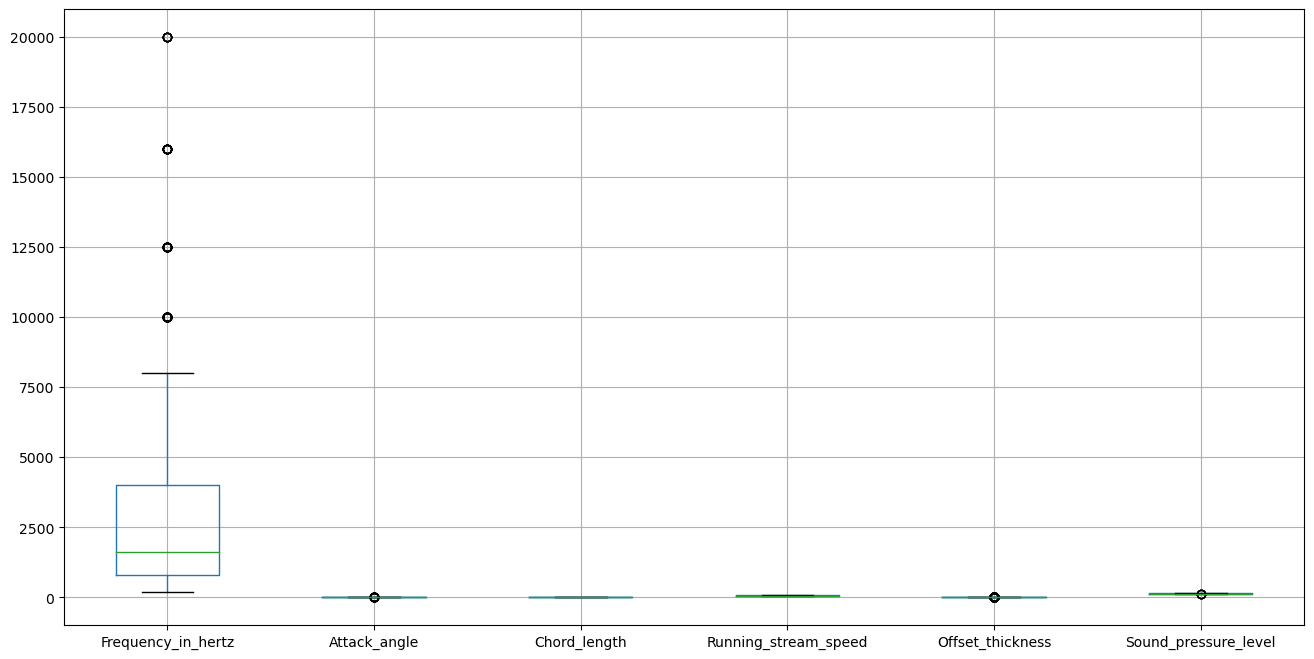

In [18]:
df.boxplot(figsize=(16,8))

При изменении масштабов построения графика выявлено наличие выбросов по верхней границе для частоты, угла атаки и толщины смещения, для уровня давления-по нижней границе. Очистка от выбросов может быть произведена методом межквартильного диапазона следующим образом:

In [19]:
#Q1 = df.quantile(q=0.25)
#Q3 = df.quantile(q=0.75)
#IQR=Q3-Q1
#df2 = df.copy(deep=True)
#df_clean2 = df2[~((df2 < (Q1-1.5*IQR)) | (df2 > (Q3+1.5*IQR))).any(axis=1)]

In [20]:
z = np.abs(stats.zscore(df))
df2 = df.copy(deep=True)
df_clean2 = df2[(z<3).all(axis=1)]

In [21]:
df_clean2.describe()

,Frequency_in_hertz,Attack_angle,Chord_length,Running_stream_speed,Offset_thickness,Sound_pressure_level
count,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000
mean,2549.362299,6.784163,0.136950,50.821374,0.010432,125.289425
std,2416.312023,5.884819,0.094009,15.623265,0.011588,6.572827
min,200.000000,0.000000,0.025400,31.700000,0.000401,107.147000
25%,800.000000,2.000000,0.050800,39.600000,0.002663,120.630500
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,126.097000
75%,4000.000000,9.900000,0.228600,71.300000,0.015048,130.178000
max,10000.000000,22.200000,0.304800,71.300000,0.048316,140.987000


Таким образом, данные подготовлены к построению модели. Для построения оптимальной регрессии предлагается сравнить ее качество на исходных и очищенных данных.

In [22]:
y = df.pop('Sound_pressure_level')
X = df

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [190]:
y1 = df_clean1.pop('Sound_pressure_level')
X1 = df_clean1

In [191]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2)

In [26]:
y2 = df_clean2.pop('Sound_pressure_level')
X2 = df_clean2

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2)

# Подбор модели регрессии

## 1. Линейная регрессия

Исходный датафрейм:

In [45]:
LR = LinearRegression()
LR.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(LR.score(X_train, y_train),LR.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(LR, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52703, for test set: 0.45234.
Cross-validation score: 0.40983.


Датафрейм без столбца "угол атаки":

In [46]:
LR1 = LinearRegression()
LR1.fit(X_train1, y_train1)
print('R2-score for train set 1: {:.5f}, for test set 1: {:.5f}.'.format(LR1.score(X_train1, y_train1),LR1.score(X_test1, y_test1)))
mean_CVS=np.mean(cross_val_score(LR1, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set 1: 0.47216, for test set 1: 0.49440.
Cross-validation score: 0.40983.


Датафрейм без выбросов:

In [142]:
LR2 = LinearRegression()
LR2.fit(X_train2, y_train2)
print('R2-score for train set 2: {:.5f}, for test set 2: {:.5f}.'.format(LR2.score(X_train2, y_train2),LR2.score(X_test2, y_test2)))
mean_CVS=np.mean(cross_val_score(LR2, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set 2: 0.46677, for test set 2: 0.55012.
Cross-validation score: 0.40983.


Таким образом, наилучшие результаты на тестовом множестве показала модель, обученная на исходном датафрейме. Ее параметры таковы:

In [ ]:
print('коэффициенты регрессии: ', LR.coef_)
print('свободная переменая: ',LR.intercept_)

В ходе дальнейшей настройки модели также будут обучаться с применением исходных данных в целях экономии времени.

## 2. Линейная регрессия+масштабирование

Применим минимаксную масштабацию к линейной модели:

In [48]:
LR_mm = Pipeline([('scaler', MinMaxScaler()),
               ('regression', LinearRegression())])
LR_mm.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(LR_mm.score(X_train, y_train),LR_mm.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(LR_mm, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52703, for test set: 0.45234.
Cross-validation score: 0.40983.


Стандартное масштабирование:

In [49]:
LR_st = Pipeline([('scaler', StandardScaler()),
                  ('regression', LinearRegression())])
LR_st .fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(LR_st.score(X_train, y_train),LR_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(LR_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52703, for test set: 0.45234.
Cross-validation score: 0.40983.


Масштабирование не улучшает качество модели, следовательно, линейная модель регрессии не подходит. Попробуем применить регуляризацию.

## 3. Регрессия с регуляризацией+масштабирование

Модель, основанная на минимаксном масштабировании и Лассо-регрессии (гиперпараметр подбирался вручную для максимизации значения на тестовой выборке):

In [65]:
L1_mm = Pipeline([('scaler', MinMaxScaler()),
                  ('regression', Lasso(alpha = 0.02))])
L1_mm.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(L1_mm.score(X_train, y_train),L1_mm.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(L1_mm, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52588, for test set: 0.45310.
Cross-validation score: 0.40855.


Модель, основанная на стандартном масштабировании и Лассо-регрессии (гиперпараметр подбирался вручную для максимизации значения на тестовой выборке):

In [86]:
L1_st = Pipeline([('scaler', StandardScaler()),
                  ('regression', Lasso(alpha = 0.1))])
L1_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(L1_st.score(X_train, y_train),L1_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(L1_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52523, for test set: 0.45409.
Cross-validation score: 0.40676.


In [ ]:
Модель, основанная на минимаксном масштабировании и Ридж-регрессии (гиперпараметр подбирался вручную для максимизации значения на тестовой выборке):

In [93]:
L2_mm = Pipeline([('scaler', MinMaxScaler()),
                  ('regression', Ridge(alpha = 0.9))])
L2_mm.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(L2_mm.score(X_train, y_train),L2_mm.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(L2_mm, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52657, for test set: 0.45286.
Cross-validation score: 0.41408.


In [ ]:
Модель, основанная на стандартном масштабировании и Ридж-регрессии (гиперпараметр подбирался вручную для максимизации значения на тестовой выборке):

In [106]:
L2_st = Pipeline([('scaler', StandardScaler()),
                  ('regression', Ridge(alpha =38))])
L2_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(L2_st.score(X_train, y_train),L2_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(L2_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.52555, for test set: 0.45392.
Cross-validation score: 0.41295.


ПЕРЕОБУЧ
Таким образом, для настраиваемой модели лучше подходят Ридж регрессия и стандартное масштабирование, однако качество модели по-прежнему остается низким, потому следует применить полиномиальную регрессию.

## 4. Полиномиальная регрессия + ...

### 4.1. Линейная 

Для начала построим полином, основанный на линейной регрессии и стандартном масштабировании, которое будем применять во всех дальнейших моделях. Подбор степени полинома осуществим с помощью цикла:

In [112]:
for i in range(1, 11):
    PR_st = Pipeline([('poly', PolynomialFeatures(degree = i)),
                   ('scaler', StandardScaler()),
                   ('regression', LinearRegression())])
    PR_st.fit(X_train, y_train)
    print('Degree=',i,'- R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_st.score(X_train, y_train),PR_st.score(X_test, y_test)))

Degree= 1 - R2-score for train set: 0.52703, for test set: 0.45234.
Degree= 2 - R2-score for train set: 0.65358, for test set: 0.59302.
Degree= 3 - R2-score for train set: 0.76961, for test set: 0.69753.
Degree= 4 - R2-score for train set: 0.86569, for test set: 0.78178.
Degree= 5 - R2-score for train set: 0.91152, for test set: 0.73176.
Degree= 6 - R2-score for train set: 0.93863, for test set: 0.49350.
Degree= 7 - R2-score for train set: 0.96188, for test set: -2.83516.
Degree= 8 - R2-score for train set: 0.97676, for test set: -114.03077.
Degree= 9 - R2-score for train set: 0.97583, for test set: -6194.96964.
Degree= 10 - R2-score for train set: 0.98858, for test set: -1116961096.78920.


Валидационная кривая при указанных степенях полинома будет иметь вид:

Наилучшие результаты на тестовой выборке получены при 4 степени полинома. Модель такого вида будет иметь вид:

In [121]:
PR_st = Pipeline([('poly', PolynomialFeatures(degree = 4)),
               ('scaler', StandardScaler()),
               ('regression', LinearRegression())])
PR_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_st.score(X_train, y_train),PR_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(PR_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.86569, for test set: 0.78178.
Cross-validation score: -15153.11762.


Произошло увеличение качества модели по оценке R2 практически в 2 раза, но оно сопровождалось значительным ухудшением значения при валидации. Построим график зависимости качества модели от степени.

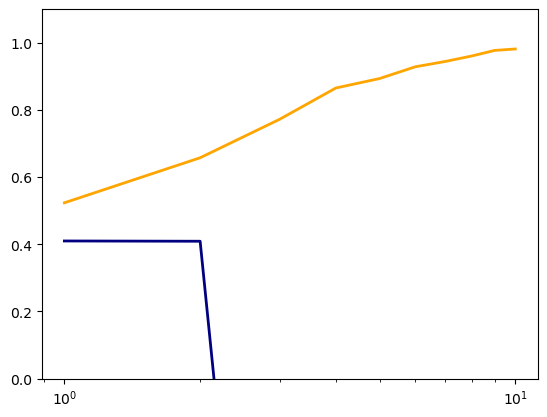

In [113]:
param_range=range(1,11)

train_sc, test_sc=validation_curve(PR_st, X, y,param_name="poly__degree", param_range=param_range, cv=5)
train_sc

train_sc_mean=np.mean(train_sc, axis=1)
test_sc_mean=np.mean(test_sc, axis=1)
plt.ylim(0.0,1.1)
lw=2
plt.semilogx(param_range, train_sc_mean,color='orange',lw=lw)
plt.semilogx(param_range, test_sc_mean,color='navy',lw=lw)

Согласно этому методу, оптимален будет полином 2 степени:

In [120]:
PR_st = Pipeline([('poly', PolynomialFeatures(degree = 2)),
               ('scaler', StandardScaler()),
               ('regression', LinearRegression())])
PR_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_st.score(X_train, y_train),PR_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(PR_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.65358, for test set: 0.59302.
Cross-validation score: 0.40903.


### 2. Лассо

Модель полинома с Лассо-регуляризацией будет иметь вид:

In [135]:
PR_L1_st = Pipeline([('poly', PolynomialFeatures(degree = 5)),
                  ('scaler', StandardScaler()),
                  ('regression', Lasso(alpha = 0.1,max_iter = 2000))])
PR_L1_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_L1_st.score(X_train, y_train),PR_L1_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(PR_L1_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.70954, for test set: 0.65693.
Cross-validation score: 0.56033.


Первоначальный подбор оптимальных гиперпараметров был осуществлен с помощью поиска по сетке. 

In [126]:
params={'poly__degree':range(1,11),
        'regression__alpha':[10, 5, 1, 0,5, 0.1, 0.05, 0.01, 0.005, 0.001]}
grid=GridSearchCV(PR_L1_st,params,cv=5)
grid.fit(X,y)
grid.best_params_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+04, tolerance: 6.056e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e+04, tolerance: 6.056e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.445e+03, tolerance: 5.773e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.926e+03, tolerance: 5.454e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.294e+03, tolerance: 5.454e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.722e+01, tolerance: 5.454e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+01, tolerance: 5.421e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.546e+02, toleranc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.585e+03, tolerance: 5.421e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.421e+02, tolerance: 5.773e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+03, tolerance: 5.421e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.053e+03, toleranc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.843e+03, tolerance: 5.837e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+03, tolerance: 5.421e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the num

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e+03, tolerance: 5.773e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e+03, tolerance: 5.837e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e+02, tolerance: 6.056e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+02, tolerance: 5.837e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+02, toleranc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e+03, tolerance: 5.773e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+02, tolerance: 5.421e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.351e+02, tolerance: 6.056e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.425e+02, toleranc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e+03, tolerance: 5.421e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.915e+02, tolerance: 5.837e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.220e+02, tolerance: 5.454e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.834e+02, toleranc

{'poly__degree': 5, 'regression__alpha': 0.1}

Так как в список потенциальных альфа для ускорения обработки были переданы дискретные величины, для улучшения модели были проверены близкие к ним значения на предмет улучшения качества R2 на тестовой выборке.

### 3. Ридж

Аналогично модель полинома с Ридж-регуляризацией будет иметь вид:

In [161]:
PR_L2_st = Pipeline([('poly', PolynomialFeatures(degree = 3)),
                  ('scaler', StandardScaler()),
                  ('regression', Ridge(alpha = 10, max_iter = 2000))])
PR_L2_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_L2_st.score(X_train, y_train),PR_L2_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(PR_L2_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.69284, for test set: 0.64154.
Cross-validation score: 0.55979.


Подбор оптимальных гиперпараметров также был осуществлен с помощью поиска по сетке:

In [145]:
params={'poly__degree':range(1,11),
        'regression__alpha':[10, 5, 1, 0,5, 0.1, 0.05, 0.01, 0.005, 0.001]}
grid=GridSearchCV(PR_L2_st,params,cv=5)
grid.fit(X,y)
grid.best_params_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_mo

{'poly__degree': 3, 'regression__alpha': 50}

Так как в список потенциальных альфа для ускорения обработки были переданы дискретные величины, для улучшения модели были проверены близкие к ним значения на предмет улучшения качества R2 на тестовой выборке.

In [179]:
PR_L2_st = Pipeline([('poly', PolynomialFeatures(degree = 6)),
                  ('scaler', StandardScaler()),
                  ('regression', Ridge(alpha =2, max_iter = 2000))])
PR_L2_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_L2_st.score(X_train, y_train),PR_L2_st.score(X_test, y_test)))
mean_CVS=np.mean(cross_val_score(PR_L2_st, X, y, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.84204, for test set: 0.77811.
Cross-validation score: -1.04470.


# Заключение

In [201]:
PR_st = Pipeline([('poly', PolynomialFeatures(degree = 5)),
               ('scaler', StandardScaler()),
               ('regression', LinearRegression())])
PR_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_st.score(X_train2, y_train2),PR_st.score(X_test2, y_test2)))
mean_CVS=np.mean(cross_val_score(PR_st, X2, y2, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.85896, for test set: 0.88554.
Cross-validation score: -20681956192180693368832.00000.


In [212]:
PR_L2_st = Pipeline([('poly', PolynomialFeatures(degree = 20)),
                  ('scaler', StandardScaler()),
                  ('regression', Ridge(alpha = 10, max_iter = 2000))])
PR_L2_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_L2_st.score(X_train2, y_train2),PR_L2_st.score(X_test2, y_test2)))
mean_CVS=np.mean(cross_val_score(PR_L2_st, X2, y2, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.79339, for test set: 0.83229.
Cross-validation score: -10609.98594.


In [181]:
PR_L1_st = Pipeline([('poly', PolynomialFeatures(degree = 5)),
                  ('scaler', StandardScaler()),
                  ('regression', Lasso(alpha = 0.1,max_iter = 2000))])
PR_L1_st.fit(X_train, y_train)
print('R2-score for train set: {:.5f}, for test set: {:.5f}.'.format(PR_L1_st.score(X_train2, y_train2),PR_L1_st.score(X_test2, y_test2)))
mean_CVS=np.mean(cross_val_score(PR_L1_st, X2, y2, cv = 5))
print('Cross-validation score: {:.5f}.'.format(mean_CVS))

R2-score for train set: 0.65083, for test set: 0.69651.
Cross-validation score: 0.55067.


In [213]:
Кроме того, бывают случаи, когда коэффициент детерминации принимает отрицательные значения (обычно небольшие). Это случается, когда ошибка модели простого среднего становится меньше ошибки регрессионной модели. Таким образом, добавление в модель с константой некоторой переменной только ухудшает её.

SyntaxError: invalid syntax (1515772792.py, line 1)

PR_st.named_steps.regression.coef_

In [ ]:
PR_st.named_steps.regression.intercept